In [1]:
# semantic segmentation with VOC dataset
# reference : https://www.kaggle.com/code/gopalbhattrai/pascal-voc-2012-image-segmentation-using-fcn/notebook

import gc
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers
import os
from PIL import Image
from albumentations import RandomRotate90

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_data(path, is_train=True):
    file_list_path = os.path.join(path,"VOC2011", "ImageSets", "Segmentation", "train.txt" if is_train else "val.txt")

    dataset = []
    with open(file_list_path, "r") as f:
        file_list = f.read().split()

        for file in file_list:
            input_path = os.path.join(path, "VOC2011", "JPEGImages", file+".jpg")
            label_path = os.path.join(path, "VOC2011", "SegmentationClass", file+".png")
            dataset.append([input_path, label_path])

    return dataset

In [3]:
train_path = read_data("data", is_train=True)
valid_path = read_data("data", is_train=False)

train_path = tf.random.shuffle(train_path)
valid_path = tf.random.shuffle(valid_path)

num_classes = 20
img_width, img_height = 224, 224
# from_tensor_slice : 데이터를 슬라이스하여 dataset 생성
train_ds = tf.data.Dataset.from_tensor_slices(train_path)
valid_ds = tf.data.Dataset.from_tensor_slices(valid_path)

# 연산 과정은 float16, weight update는 float32로 실행하도록 설정
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [4]:
def create_mask(img):
    seg_labels = np.zeros((img.shape[0], img.shape[1], num_classes), dtype=np.float16)

    for class_ in range(num_classes):
        seg_labels[:, :, class_] = (img==class_)

    return tf.cast(seg_labels, dtype=tf.float16)

# 전처리 적용
def create_preprocess_mask_img(instance):
    img = Image.open(instance[0].numpy())
    img = img.resize((img_width, img_height), resample=Image.BILINEAR)
    img = np.asarray(img)

    mask = Image.open(instance[1].numpy())
    mask = mask.resize((img_width, img_height), resample=Image.BILINEAR)
    mask = np.asarray(mask)

    nomalization = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

    if tf.random.uniform(()) > 0.5:
        aug = RandomRotate90(p=0.5)
        augmented = aug(image = img, mask=mask)

        img = augmented["image"]
        mask = augmented["mask"]

    return nomalization(img), create_mask(mask)

In [5]:
def preprocess(instance):
    img, mask = tf.py_function(create_preprocess_mask_img, [instance], [tf.float16, tf.float16])

    return tf.ensure_shape(img, [None, None, 3]), tf.ensure_shape(mask, [None, None, num_classes])

In [6]:
def DataLoader(dataset, batch_size=2, buffer_size=2):
    data = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    data = data.cache().shuffle(buffer_size).batch(batch_size).repeat(1)
    data = data.prefetch(buffer_size=tf.data.AUTOTUNE)

    return data

In [7]:
train = DataLoader(train_ds)
valid = DataLoader(valid_ds)

In [8]:
Q = []
for X,Y in valid.take(1):
  print(X.shape)
  Q = Y
  print(Y.shape)

(2, 224, 224, 3)
(2, 224, 224, 20)


In [9]:
def FCN_VGG8():
    input = layers.Input(shape=[img_width, img_height, 3])

    conv1 = layers.Conv2D(64, kernel_size=3, strides=1, padding="same", activation="relu")(input)
    conv2 = layers.Conv2D(64, kernel_size=3, strides=1, padding="same", activation="relu")(conv1)
    pool1 = layers.MaxPool2D(pool_size=2, strides=2)(conv2)

    conv3 = layers.Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu")(pool1)
    conv4 = layers.Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu")(conv3)
    pool2 = layers.MaxPool2D(pool_size=2, strides=2)(conv4)

    conv5 = layers.Conv2D(256, kernel_size=3, strides=1, padding="same", activation="relu")(pool2)
    conv6 = layers.Conv2D(256, kernel_size=3, strides=1, padding="same", activation="relu")(conv5)
    conv7 = layers.Conv2D(256, kernel_size=3, strides=1, padding="same", activation="relu")(conv6)
    pool3 = layers.MaxPool2D(pool_size=2, strides=2)(conv7)

    conv8 = layers.Conv2D(512, kernel_size=3, strides=1, padding="same", activation="relu")(pool3)
    conv9 = layers.Conv2D(512, kernel_size=3, strides=1, padding="same", activation="relu")(conv8)
    conv10 = layers.Conv2D(512, kernel_size=3, strides=1, padding="same", activation="relu")(conv9)
    pool4 = layers.MaxPool2D(pool_size=2, strides=2)(conv10)

    conv11 = layers.Conv2D(512, kernel_size=3, strides=1, padding="same", activation="relu")(pool4)
    conv12 = layers.Conv2D(512, kernel_size=3, strides=1, padding="same", activation="relu")(conv11)
    conv13 = layers.Conv2D(512, kernel_size=3, strides=1, padding="same", activation="relu")(conv12)
    pool5 = layers.MaxPool2D(pool_size=2, strides=2)(conv13)

    # fully convolutional layer
    fc1 = layers.Conv2D(4096, kernel_size=7, activation="relu")(pool5)
    fc_drop = layers.Dropout(0.5)(fc1)
    fc2 = layers.Conv2D(4096, kernel_size=1, activation="relu")(fc_drop)
    fc_drop2 = layers.Dropout(0.5)(fc2)

    # Classification score layer
    score = layers.Conv2D(num_classes, kernel_size=1, activation="relu")(fc_drop2)

    # upsample pool4
    upscore = layers.Conv2DTranspose(num_classes, kernel_size=4, strides=2, kernel_initializer="zeros")(score)

    conv_scale = layers.Conv2D(num_classes, kernel_size=1)(pool4)
    cropped = layers.Cropping2D((5, 5))(conv_scale)

    fused = layers.add([cropped, upscore])

    upsampled_pool4 = layers.Conv2DTranspose(num_classes, kernel_size=4, strides=2, kernel_initializer="zeros")(fused)

    # upsample pool3
    conv_scale2 = layers.Conv2D(num_classes, kernel_size=1)(pool3)
    cropped2 = layers.Cropping2D((9, 9))(conv_scale2)
    fused2 = layers.add([cropped2, upsampled_pool4])

    upsampled_pool3 = layers.Conv2DTranspose(num_classes, kernel_size=128, strides=16, kernel_initializer="zeros")(fused2)

    # score per pixel
    score = layers.Cropping2D((24, 24))(upsampled_pool3)
    score = layers.Softmax(dtype="float32")(score)

    return tf.keras.Model(inputs=input, outputs=score)

In [10]:
model = FCN_VGG8()

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
VGG16 = tf.keras.applications.vgg16.VGG16(weights="imagenet")
VGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
# weight apply, freeze

for i in range(19):
    model.layers[i].set_weights(VGG16.layers[i].get_weights())

for layers in model.layers[:19]:
    layers.trainable = False

In [15]:
es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

MeanIou = tf.keras.metrics.MeanIoU(num_classes=20)

In [16]:
gc.collect()
gc.enable()

In [17]:
# 전역 상태 해제
tf.keras.backend.clear_session()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss=tf.keras.losses.categorical_crossentropy, metrics=[MeanIou])

In [18]:
epochs = 100
batch_size = 2


history = model.fit(train, validation_data=valid, batch_size=batch_size, epochs=epochs, callbacks=[es])

Epoch 1/100
556/556 [==============================] - 87s 118ms/step - loss: 1.9753 - mean_io_u: 0.4765 - val_loss: 1.6143 - val_mean_io_u: 0.4765
Epoch 2/100
556/556 [==============================] - 54s 98ms/step - loss: 1.5200 - mean_io_u: 0.4765 - val_loss: 1.5419 - val_mean_io_u: 0.4765
Epoch 3/100
556/556 [==============================] - 54s 98ms/step - loss: 1.4561 - mean_io_u: 0.4765 - val_loss: 1.5074 - val_mean_io_u: 0.4765
Epoch 4/100
556/556 [==============================] - 54s 97ms/step - loss: 1.4189 - mean_io_u: 0.4765 - val_loss: 1.4793 - val_mean_io_u: 0.4765
Epoch 5/100
556/556 [==============================] - 53s 96ms/step - loss: 1.3877 - mean_io_u: 0.4765 - val_loss: 1.4553 - val_mean_io_u: 0.4765
Epoch 6/100
556/556 [==============================] - 53s 95ms/step - loss: 1.3624 - mean_io_u: 0.4765 - val_loss: 1.4381 - val_mean_io_u: 0.4765
Epoch 7/100
556/556 [==============================] - 52s 94ms/step - loss: 1.3406 - mean_io_u: 0.4765 - val_loss: 1

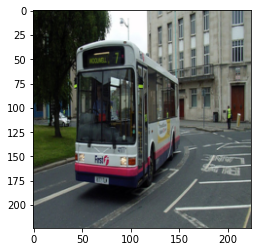

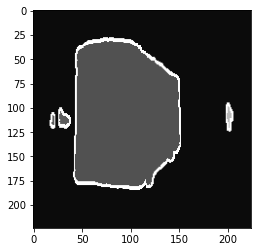

In [152]:
import matplotlib.pyplot as plt

color_mapping = {}  # 클래스 별 픽셀 색상
for i in range(num_classes):
    color_mapping[i] = (1/22*(i+1), 1/22*(i+1), 1/22*(i+1))

index = 0
for X,Y in valid.take(6):
    pass

X = X[index]*255
X = tf.cast(X, tf.uint16)
plt.imshow(X)
plt.show()
segmented_image = np.ones((224, 224, 3))
for i in range(num_classes):
    segmented_image[Y[index][:, :, i]==1] = color_mapping[i]

plt.imshow(segmented_image)
plt.show()